In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import butter, filtfilt, hilbert, convolve
import mne

raw = mne.io.read_raw_edf("/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-01/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf", preload=True)
print(raw.info)

Extracting EDF parameters from /Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-01/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 799999  =      0.000 ...   400.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: mAHL1, mAHL2, mAHL3, mAHL4, mAHL5, mAHL6, mAHL7, mAHL8, mAL1, ...
 chs: 48 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2023-09-13 10:27:08 UTC
 nchan: 48
 projs: []
 sfreq: 2000.0 Hz
 subject_info: <subject_info | his_id: <no>
>


In [2]:
from pathlib import Path

# set BIDS root directory
bids_root = Path(
    "/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main"
)

sub = "sub-01"

# find sessions
sessions = sorted([p.name for p in (bids_root / sub).glob("ses-*")])
print("Found sessions:", sessions)

ieeg_edfs = []
events_tsvs = []

for ses in sessions:
    ses_dir = bids_root / sub / ses 

    edf = next(ses_dir.glob(f"{sub}_{ses}_task-verbalWM*_ieeg.edf"))
    ev  = next(ses_dir.glob(f"{sub}_{ses}_task-verbalWM*_events.tsv"))

    ieeg_edfs.append(edf)
    events_tsvs.append(ev)

# check
for a, b in zip(ieeg_edfs, events_tsvs):
    print(a)
    print(b)

Found sessions: ['ses-01', 'ses-02', 'ses-03', 'ses-04']
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-01/sub-01_ses-01_task-verbalWM_run-01_ieeg.edf
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-01/sub-01_ses-01_task-verbalWM_run-01_events.tsv
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-02/sub-01_ses-02_task-verbalWM_run-01_ieeg.edf
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-02/sub-01_ses-02_task-verbalWM_run-01_events.tsv
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-03/sub-01_ses-03_task-verbalWM_run-01_ieeg.edf
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-03/sub-01_ses-03_task-verbalWM_run-01_events.tsv
/Users/ohadgonen/Desktop/Neuroscience/Year 3/1st semester/Erez lab/Dataset/Main/sub-01/ses-04/sub-01_ses-04_t

In [3]:
import pandas as pd
import mne
mne.set_log_level("ERROR")

edf_path = ieeg_edfs[0]
ev_path  = events_tsvs[0]

raw = mne.io.read_raw_edf(edf_path, preload=True)
events = pd.read_csv(ev_path, sep="\t")

fs = raw.info["sfreq"]
print("sfreq:", raw.info["sfreq"])
print("events columns:", list(events.columns))
print(events[["SetSize"]].value_counts().sort_index())

# separate easy vs hard trials
easy_trials = events.index[events["SetSize"] <= 4].to_numpy()
hard_trials = events.index[events["SetSize"] >= 8].to_numpy()

print("n easy:", len(easy_trials), "n hard:", len(hard_trials))

raw = mne.io.read_raw_edf(edf_path, preload=False)
print("channel number:", len(raw.ch_names))

sfreq: 2000.0
events columns: ['onset', 'duration', 'nTrial', 'begSample', 'endSample', 'SetSize', 'ProbeLetter', 'Match', 'Correct', 'ResponseTime', 'Artifact']
SetSize
4          21
6          12
8          17
Name: count, dtype: int64
n easy: 21 n hard: 17
channel number: 48


In [4]:
import numpy as np
from scipy.signal import hilbert
from mne.filter import filter_data


def compute_plv_matrix(
    raw,
    low_band,
    high_band,
    start,
    end
):
    # === Compute PLV matrix for all channel pairs ===

    fs = float(raw.info["sfreq"])

    data = raw.get_data()           # shape: (n_channels, n_samples)
    n_channels = data.shape[0]

    # Prepare PLV matrix
    plv_matrix = np.zeros((n_channels, n_channels), dtype=float)

    # Two loops over all channel couples (i,j)
    for i in range(n_channels):
        # Take channel i as the low-frequency phase channel
        ch_lf = data[i, :]

        # ---- low-band filter + Hilbert  ----
        lf_filtered = filter_data(
            ch_lf, sfreq=fs, l_freq=low_band[0], h_freq=low_band[1]
        )
        analytic_lf = hilbert(lf_filtered)
        phase_lf = np.angle(analytic_lf)

        for j in range(n_channels):
            # Take channel j as the high-frequency amplitude channel
            ch_hf = data[j, :]

            # ---- high-band filter + Hilbert ----
            hf_filtered = filter_data(
                ch_hf, sfreq=fs, l_freq=high_band[0], h_freq=high_band[1]
            )
            analytic_hf = hilbert(hf_filtered)
            amp_hf = np.abs(analytic_hf)

            analytic_hf_abs = hilbert(amp_hf)
            phase_hf = np.angle(analytic_hf_abs)

            # ---- PLV (restricted to [start:end]) ----
            phase_diff = phase_lf - phase_hf
            plv_val = np.abs(
                np.mean(np.exp(1j * phase_diff[start:end]))
            )

            # store in matrix
            plv_matrix[i, j] = plv_val

    return plv_matrix

In [39]:
low_band = (12, 30)
high_band = (70, 250)
n_channels = len(raw.ch_names)

# === Compute PLV matrices for easy vs hard trials ===

plv_easy = np.zeros((n_channels, n_channels))

for t in easy_trials:
    start = int(events.loc[t, "begSample"])
    end   = int(events.loc[t, "endSample"])

    plv_easy += compute_plv_matrix(raw, low_band, high_band, start, end)

plv_easy /= len(easy_trials)

plv_hard = np.zeros((n_channels, n_channels))
for t in hard_trials:
    start = int(events.loc[t, "begSample"])
    end   = int(events.loc[t, "endSample"])

    plv_hard += compute_plv_matrix(raw, low_band, high_band, start, end)

plv_hard /= len(hard_trials)

In [5]:
# save results - sub-01

np.save("sub-01_plv_easy.npy", plv_easy)
np.save("sub-01_plv_hard.npy", plv_hard)

NameError: name 'plv_easy' is not defined

In [6]:
# pull results - sub-01

plv_easy = np.load("sub-01_plv_easy.npy")
plv_hard = np.load("sub-01_plv_hard.npy")

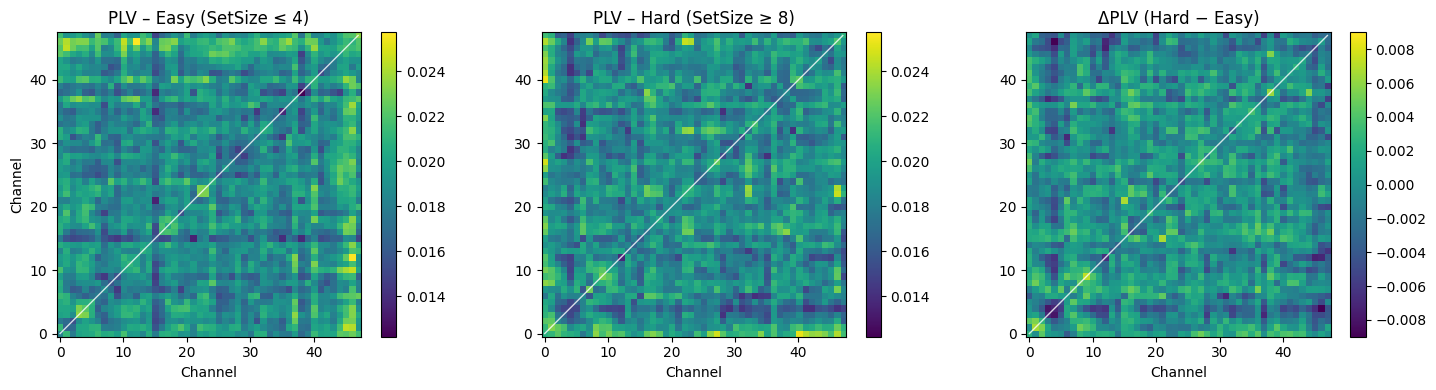

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def draw_symmetry_line(ax, n):
    ax.plot([0, n - 1], [0, n - 1], color="white", linewidth=1, alpha=0.8)
    
# --- Compute delta ---
plv_delta = plv_hard - plv_easy

n_ch = plv_easy.shape[0]

# --- Shared scale for Easy & Hard ---
vmin = min(plv_easy.min(), plv_hard.min())
vmax = max(plv_easy.max(), plv_hard.max())

# --- Symmetric scale for Delta ---
delta_max = np.max(np.abs(plv_delta))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# --- Easy ---
im0 = axes[0].imshow(
    plv_easy,
    origin="lower",
    aspect="equal",
    vmin=vmin,
    vmax=vmax
)
draw_symmetry_line(axes[0], n_ch)
axes[0].set_title("PLV – Easy (SetSize ≤ 4)")
axes[0].set_xlabel("Channel")
axes[0].set_ylabel("Channel")
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# --- Hard ---
im1 = axes[1].imshow(
    plv_hard,
    origin="lower",
    aspect="equal",
    vmin=vmin,
    vmax=vmax
)
draw_symmetry_line(axes[1], n_ch)
axes[1].set_title("PLV – Hard (SetSize ≥ 8)")
axes[1].set_xlabel("Channel")
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# --- Delta (Hard - Easy) ---
im2 = axes[2].imshow(
    plv_delta,
    origin="lower",
    aspect="equal",
    vmin=-delta_max,
    vmax=delta_max
)
draw_symmetry_line(axes[2], n_ch)
axes[2].set_title("ΔPLV (Hard − Easy)")
axes[2].set_xlabel("Channel")
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()

In [8]:
# assure symmetry

assert np.allclose(plv_easy, plv_easy.T, atol=1e-6)
assert np.allclose(plv_hard, plv_hard.T, atol=1e-6)

print(np.max(np.abs(plv_easy - plv_easy.T)))
print(np.max(np.abs(plv_hard - plv_hard.T)))

0.0
0.0


In [ ]:
# Glossary of channel names to indices

# Get all channel names
channels = raw.ch_names

# Find their indices
i_ahl5 = channels.index('mAHL5')
i_ecl1 = channels.index('mECL1')

print(f"mAHL5 index: {i_ahl5}")
print(f"mECL1 index: {i_ecl1}")

# index to channel name dictionary
index_to_name = {idx: name for idx, name in enumerate(raw.ch_names)}

# print a few examples
print(index_to_name[47])
print(index_to_name[1])

mAHL5 index: 4
mECL1 index: 16
mPHR8
mAHL2
